# Tweet Count and Sentiment Analysis during Election 2020
Name: Xiangyu Wei
<br>
PID: A14528718
<br>
Date: 12/14/20

# Project Description

P.S. The whole notebook takes around __2min 30s__ to run.

This project is a data analysis project, which focuses on the differences between _#Trump_ and _#Biden_ tweets during the 2020 presidential election across the United States of America. More specifically, I will focus on the number of tweets that is related to each hashtag during the election, and the sentiment of the tweet text related to each hashtag. 

The dataset that is used in this project is from the following link to Kaggle: https://www.kaggle.com/manchunhui/us-election-2020-tweets

The data was collected starting from Oct. 15th 2020 to Nov. 8th 2020, which was a 25-day period. The total number of tweets that were collected was around 1,727,000. The following columns were included in the datasets: `created_at`, `tweet_id`, `tweet`, `likes`, `retweet_count`, `source`, `user_id`, `user_name`, `user_screen_name`, `user_description`, `user_join_date`, `user_followers_count`, `user_location`, `lat`, `long`, `city`, `country`, `state`, `state_code`, `collected_at`.

Since this was a US presidential election, instead of analyzing worldwide tweets, I chose to only analyze tweets that were posted within the United States. It would be really interesting to see how _#Trump_ and _#Biden_ tweets differ especially in their sentiments due to events that happened during 2020, such as covid, Black Lives Matter, and White supremacy. 

# Project Code
## Import Modules
Loading all the moduels takes around __10s__.

In [1]:
import pandas as pd              # dataframe
import numpy as np               # algebra
import matplotlib.pyplot as plt  # plots
import seaborn as sns            # plots

from scipy import stats         # test statistics

# my own functions
from my_module.functions import read_csv            # select/rename columns
from my_module.functions import pivot_groups        # pivot after group by
from my_module.functions import clean_text          # clean tweets
from my_module.functions import sentiment_analysis  # sentiment analysis
from my_module.functions import stat_test           # statistical test

# test functions
from my_module.test_functions import test_read_csv            # test read_csv
from my_module.test_functions import test_pivot_groups        # test pivot_groups
from my_module.test_functions import test_clean_text          # test clean_text
from my_module.test_functions import test_sentiment_analysis  # test sentiment_analysis
from my_module.test_functions import test_stat_test           # test stat_test

# register converters
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# ignore some warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Test My Functions 

In [2]:
test_read_csv()            # test read_csv
test_pivot_groups()        # test pivot_groups
test_clean_text()          # test clean_text
test_sentiment_analysis()  # test sentiment_analysis
test_stat_test()           # test stat_test

==========       read_csv() tests all pass        ==========
==========     pivot_groups() tests all pass      ==========
==========      clean_text() tests all pass       ==========
==========  sentiment_analysis() tests all pass   ==========
==========      stat_test() tests all pass        ==========


## Load Data
Notice that only a selected columns of data are used because other columns are of no use to my analysis.

In [3]:
# columns to use, and renames of selected columns
usecols = ['created_at', 'tweet', 'likes', 'lat', 'long',
           'country', 'state', 'state_code']
renames = ['Date', 'Tweet', 'Likes', 'Latitude', 'Longitude', 
           'Country', 'State', 'State Code']

# read hashtag-trump & hashtag-biden csv as dataframe
trump = read_csv('./dataset/hashtag_donaldtrump.csv', usecols, renames)
biden = read_csv('./dataset/hashtag_joebiden.csv', usecols, renames)

In [4]:
# add category to each dataframe
trump['Hashtag'] = 'Trump'
biden['Hashtag'] = 'Biden'

# concatenate trump & biden dataframe together
election_tweet = pd.concat([trump, biden])

# get US election tweets only
us_election_tweet = election_tweet[election_tweet['Country'] == 'United States of America']

# just analyzing 50 states + D.C.
isnas = pd.isna(us_election_tweet['State'])                              # find nan entries
deleted = [state in ['Puerto Rico', 'Guam', 'Northern Mariana Islands']  # delete non-50 states
           for state in us_election_tweet['State']]

selected = [not (isna or delete) for isna,delete in zip(isnas, deleted)] # criterion selected
us_election_tweet_selected = (us_election_tweet[selected]                # select states
                              .reset_index(drop=True))                   # reset index
us_election_tweet_selected.sample(5)

,Date,Tweet,Likes,Latitude,Longitude,Country,State,State Code,Hashtag
106716,2020-11-01,Biden Plans Last-Minute Visit to Pittsburgh Af...,0.0,40.712728,-74.006015,United States of America,New York,NY,Trump
140195,2020-11-05,@NBCNews LIVE - Every Body Out Anti Fascist Ma...,0.0,37.957702,-121.290780,United States of America,California,CA,Trump
13531,2020-10-17,Vote for America! Vote for American Jobs/Busin...,0.0,37.779026,-122.419906,United States of America,California,CA,Trump
70975,2020-10-26,@djvlad Trash 🗑️ rappers love #Trump 😂,0.0,42.378877,-72.032366,United States of America,Massachusetts,MA,Trump
144833,2020-11-05,Going live at 3pm PST TODAY with @412anon87 we...,132.0,39.526121,-119.812658,United States of America,Nevada,NV,Trump


## Tweet Count Analysis
First, it would be interesting to simply analyze whether there is difference between the number of tweets related to each hashtag.
### Total Tweet Count

In [5]:
# total number of tweets by each 'Hashtag'
counts_total = (pd.DataFrame(
    us_election_tweet_selected['Hashtag']
    .value_counts())
                .reset_index(drop = False))

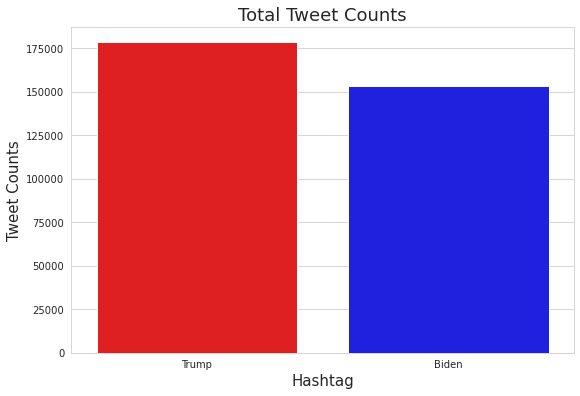

In [6]:
# set figure size
plt.figure(figsize=(9, 6))

# main plot - total counts for each 'Hashtag'
sns.set_style('whitegrid')
ax = sns.barplot(x = 'index', y = 'Hashtag', 
                 palette = ['red', 'blue'],
                 data = counts_total)

# plot style
ax.set_title('Total Tweet Counts', fontsize = 18)
ax.set_xlabel('Hashtag', fontsize = 15)
ax.set_ylabel('Tweet Counts', fontsize = 15)
plt.show()

From the graph above, we can see that the number of tweets related to Trump were higher than the number of tweets related to Biden.

### Tweet Count Over Time

In [7]:
# count the number of tweets based on 'Date', and 'Hashtag'
counts_timeseries = pivot_groups(us_election_tweet_selected, 'Date', 'Hashtag')

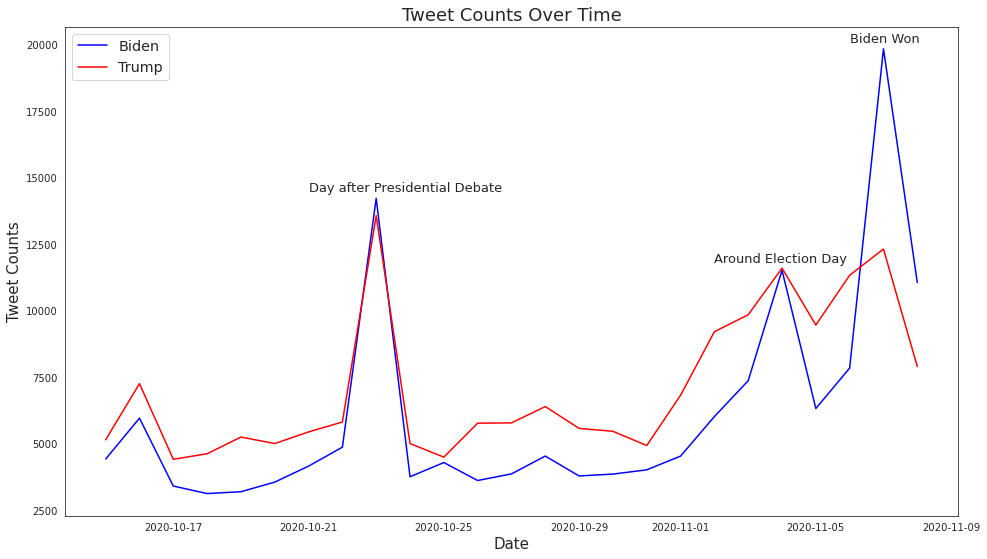

In [8]:
# set figure size
plt.figure(figsize=(16, 9))

# main plot - 'Tweet' counts over 'Date'
sns.set_style('white')
ax = sns.lineplot(data = counts_timeseries,  # specify dataframe to plot
                  palette = ['blue', 'red'], # specify color
                  dashes = False)            # solid line

# annotation
ax.annotate('Day after Presidential Debate', 
            xy = ('2020-10-22', 14500),
            xytext = ('2020-10-21', 14500),
            fontsize = 13)

ax.annotate('Around Election Day', 
            xy = ('2020-11-04', 11800),
            xytext = ('2020-11-02', 11800),
            fontsize = 13)

ax.annotate('Biden Won', 
            xy = ('2020-11-07', 20100),
            xytext = ('2020-11-06', 20100),
            fontsize = 13)

# plot style
ax.set_title('Tweet Counts Over Time', fontsize = 18)
ax.set_xlabel('Date', fontsize = 15)
ax.set_ylabel('Tweet Counts', fontsize = 15)
ax.legend(fontsize = 'x-large')
plt.show()

From the above graph we can see that overall there were more tweets related to Trump than tweets related to Biden. But during the final presidential debate and the election day, the number of tweets related to Biden was around the same as the number of tweets related to Trump. On Nov. 7th 2020 when people know for sure that Biden won the election, the number of tweets related to Biden increased significantly and surpass tweets related to Trump.  

### Tweet Count by State

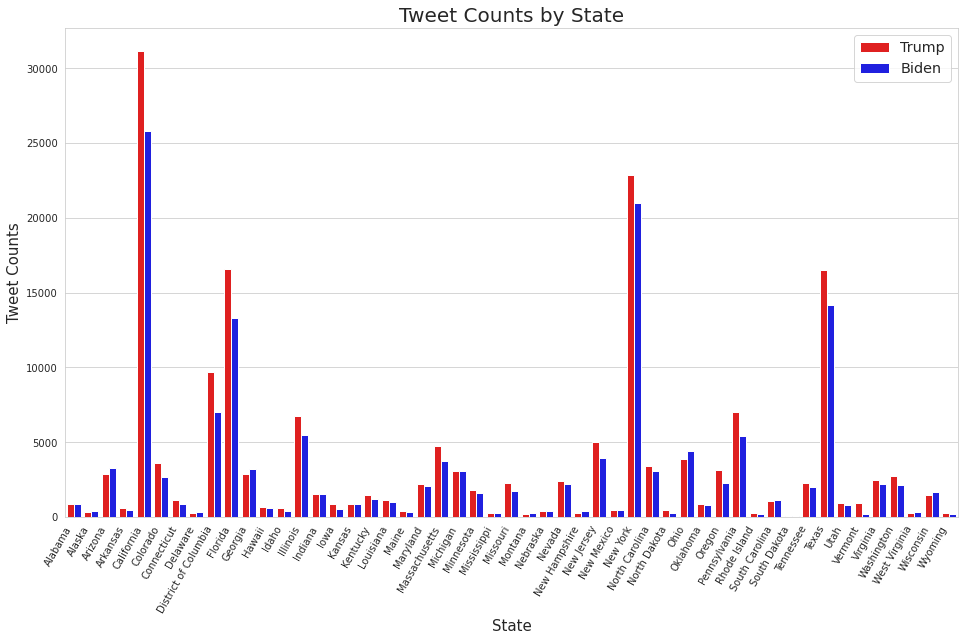

In [9]:
# set figure size
plt.figure(figsize=(16, 9))

# main plot - counts for each 'Hashtag' by 'State'
sns.set_style('whitegrid')
ax = sns.countplot(x = 'State', hue = 'Hashtag', 
                   palette = ['red', 'blue'],
                   data = (us_election_tweet_selected
                           .sort_values(by = 'State')))

# plot style
ax.set_title('Tweet Counts by State', fontsize = 20)
ax.set_xlabel('State', fontsize = 15)
ax.set_ylabel('Tweet Counts', fontsize = 15)
ax.legend(fontsize = 'x-large')
plt.xticks(rotation = 60, ha = 'right')
plt.show()

From the graph above, we can see that overall it seemed that the number of tweets related to Trump were higher than the number of tweets related to Biden across many states, with California, New York, Texas, and Florida having the highest four total number of state-wise tweet counts. To test whether the number of tweets were significantly different across states for each hashtag, a paired t-test is conducted as follows.

### Tweet Counts Distribution across States

In [10]:
# count the number of tweets based on 'State', and 'Hashtag'
counts_by_state = pivot_groups(us_election_tweet_selected, 'State', 'Hashtag', reset = True)

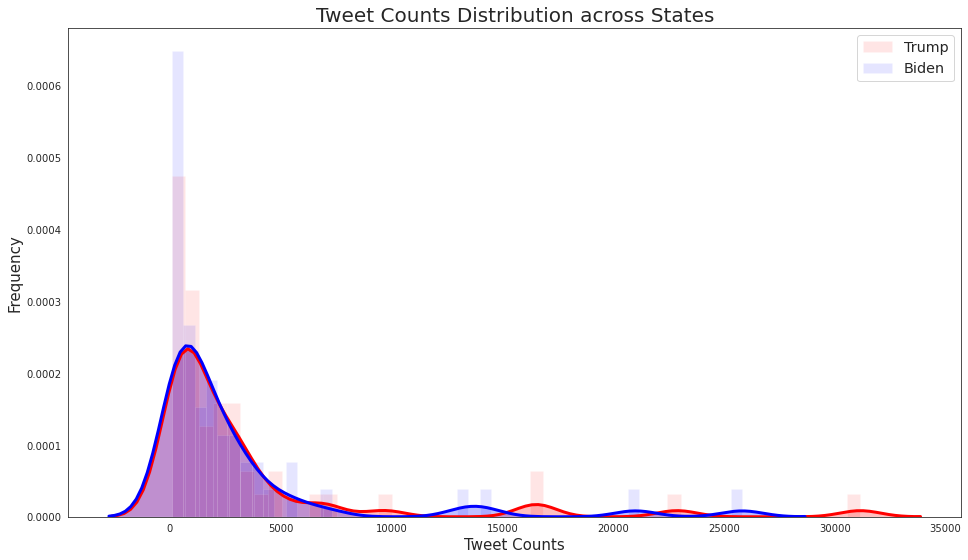

In [11]:
# set figure size
plt.figure(figsize=(16, 9))

# main plots - distribution of 'Tweet' counts
sns.set_style('white')
for hashtag,color in zip(['Trump', 'Biden'], ['red', 'blue']):
    sns.distplot(counts_by_state[hashtag], hist = True, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 hist_kws={'alpha': 0.1, 'color': color},
                 label = hashtag, bins = 50, color = color)

# plot style
plt.title('Tweet Counts Distribution across States', fontsize = 20)
plt.xlabel('Tweet Counts', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.legend(fontsize = 'x-large')
plt.show()

In [12]:
# paired t-test to test whether Trump & Biden 'Tweet' counts are significantly different across 'State'
paired_name = 'Paired T-Test      : Difference between #Trump & #Biden Tweet Counts'

paired_tstat, paired_pval = stat_test(counts_by_state['Trump'],  # collection 1: Trump 'Tweet' counts
                                      counts_by_state['Biden'],  # collection 2: Biden 'Tweet' counts
                                      paired_name,               # print out name
                                      test = stats.ttest_rel)    # test type: paired t-test

Paired T-Test      : Difference between #Trump & #Biden Tweet Counts
T-Statistic        : 3.4418
P-value            : 0.0012


From the above paired t-test, we can see that p = 0.0012 < 0.05, which means that the number of tweets related to Trump was signifcantly higher than the number of tweets related to Biden across states.

## Tweet Text Sentiment Analysis
Other than simple analyzing the number of tweets, the sentiments of the tweet text are also worth investigating.
### Data Cleaning & Sentiment Analysis
The following cell takes around __2 min__ to run.

To analyze the sentiment, I would first need to clean the tweet to strip any unrelated information such as punctuations, '\n' new line characters, links embedded in the text, etc. Then, I would need to acutally calculate a score for the sentiment of the text. To do so, I used a python package callled `TextBlob` which could simply extract the polarity of the text by calculating its polarity score. If the score is positive, then the text sentiment is positive; if negative, then the text sentiment is negative; if zero, then the text sentiment is neutral.

In [13]:
# get the polarity value from tweet text
us_election_tweet_selected[['Polarity', 'Sentiment']] = list((us_election_tweet_selected['Tweet']
                                                              .apply(clean_text)
                                                              .apply(sentiment_analysis)))

In [14]:
us_election_tweet_selected.sample(5)

,Date,Tweet,Likes,Latitude,Longitude,Country,State,State Code,Hashtag,Polarity,Sentiment
167023,2020-11-07,He should be tried and convicted for every law...,1.0,41.505161,-81.693445,United States of America,Ohio,OH,Trump,-0.400000,NEGATIVE
73261,2020-10-27,Jews backing Biden are the real 'freiers' - op...,0.0,34.053691,-118.242766,United States of America,California,CA,Trump,0.100000,POSITIVE
327498,2020-11-08,@DonaldJTrumpJr How f*kin’ awesome to hear an ...,0.0,38.894992,-77.036558,United States of America,District of Columbia,DC,Biden,0.900000,POSITIVE
9224,2020-10-16,The whole exchange with @icecube should show ...,0.0,35.773008,-86.282008,United States of America,Tennessee,TN,Trump,-0.029167,NEGATIVE
49388,2020-10-23,Pres. Trump talks about distributing a vaccine...,0.0,37.779026,-122.419906,United States of America,California,CA,Trump,0.000000,NEUTRAL


### Tweet Text Polarity by Hashtag

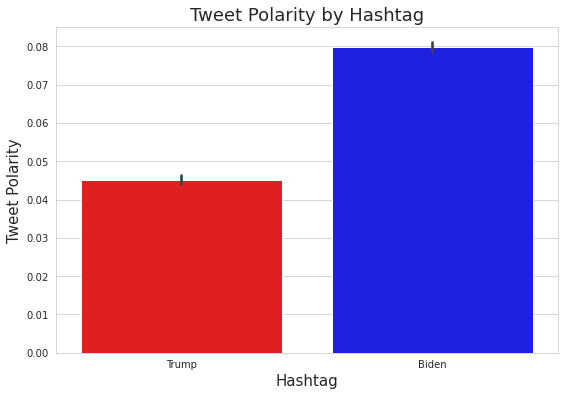

In [15]:
# set figure size
plt.figure(figsize=(9, 6))

# main plot - total counts for each 'Hashtag'
sns.set_style('whitegrid')
ax = sns.barplot(x = 'Hashtag', y = 'Polarity', 
                 palette = ['red', 'blue'],
                 data = us_election_tweet_selected)

# plot style
ax.set_title('Tweet Polarity by Hashtag', fontsize = 18)
ax.set_xlabel('Hashtag', fontsize = 15)
ax.set_ylabel('Tweet Polarity', fontsize = 15)
plt.show()

From the above graph, we can tell that Trump-related tweet sentiments were on average lower / more negative than Biden-related tweet sentiments. To test whether this difference is significant, I used an independent t-test to test for its difference.

In [16]:
# independent t-test to test whether Trump & Biden tweet 'Polarity' are significantly different
trump_polarity = us_election_tweet_selected[us_election_tweet_selected['Hashtag'] == 'Trump']['Polarity']
biden_polarity = us_election_tweet_selected[us_election_tweet_selected['Hashtag'] == 'Biden']['Polarity']
ind_name = 'Independent T-Test : Difference between #Trump & #Biden Tweet Polarity'

ind_tstat, ind_pval = stat_test(trump_polarity,         # collection 1: Trump 'Polarity'
                                biden_polarity,         # collection 2: Biden 'Polarity'
                                ind_name,               # print out name
                                test = stats.ttest_ind) # test type: independent t-test

Independent T-Test : Difference between #Trump & #Biden Tweet Polarity
T-Statistic        : -37.7606
P-value            : 0.0


From the test output above, we can see that p = 0.0 < 0.05, which means that the tweet sentiments of Trump-related tweets were signficaintly lower / more negative than tweet sentiment of Biden-related tweets.

### Tweet Text Polarity by Tweet Sentiment
I also separate the tweets by its tweet sentiment (i.e. POSITIVE, NEGATIVE) to see how Trump related tweets and Biden-related tweets differ across different tweet sentiment. I excluded NEUTRAL tweet sentiment because the score would essentially be 0, and there is no point of testing the difference.

In [17]:
# exclude neutral to plot and test for differences
tweet_polarity = us_election_tweet_selected[us_election_tweet_selected['Sentiment'] != 'NEUTRAL']

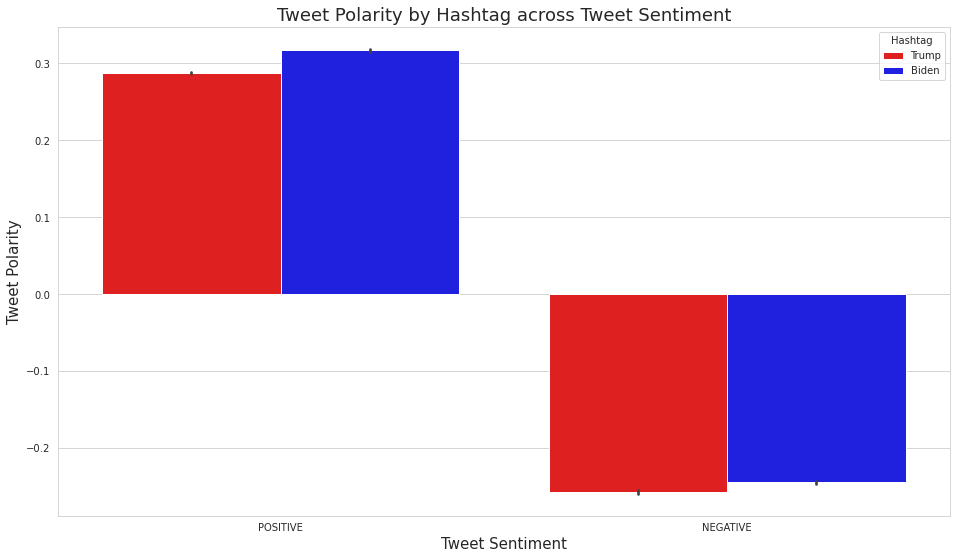

In [18]:
# set figure size
plt.figure(figsize=(16, 9))

# main plot - total counts for each 'Hashtag'
sns.set_style('whitegrid')
ax = sns.barplot(x = 'Sentiment', y = 'Polarity', 
                 hue = 'Hashtag', palette = ['red', 'blue'],
                 data = tweet_polarity)

# plot style
ax.set_title('Tweet Polarity by Hashtag across Tweet Sentiment', fontsize = 18)
ax.set_xlabel('Tweet Sentiment', fontsize = 15)
ax.set_ylabel('Tweet Polarity', fontsize = 15)
plt.show()

In [19]:
# independent t-test to test whether Trump & Biden POSITIVE tweet 'Polarity' are significantly different
tweet_polarity_positive = tweet_polarity[tweet_polarity['Sentiment'] == 'POSITIVE']
trump_polarity_pos = tweet_polarity_positive[tweet_polarity_positive['Hashtag'] == 'Trump']['Polarity']
biden_polarity_pos = tweet_polarity_positive[tweet_polarity_positive['Hashtag'] == 'Biden']['Polarity']
ind_name_pos = 'Independent T-Test : Difference between #Trump & #Biden POSITIVE Tweet Polarity'

ind_tstat_pos, ind_pval_pos = stat_test(trump_polarity_pos,     # collection 1: Trump POSITIVE 'Polarity'
                                        biden_polarity_pos,     # collection 2: Biden POSITIVE 'Polarity'
                                        ind_name_pos,           # print out name
                                        test = stats.ttest_ind) # test type: independent t-test

Independent T-Test : Difference between #Trump & #Biden POSITIVE Tweet Polarity
T-Statistic        : -23.7025
P-value            : 0.0


From the above test output, we can tell that p = 0.0 < 0.05, which means that when text sentiment is positive, Trump-related tweets were still significantly less possitive than Biden-related tweets. 

In [20]:
# independent t-test to test whether Trump & Biden NEGATIVE tweet 'Polarity' are significantly different
tweet_polarity_negative = tweet_polarity[tweet_polarity['Sentiment'] == 'NEGATIVE']
trump_polarity_neg = tweet_polarity_negative[tweet_polarity_negative['Hashtag'] == 'Trump']['Polarity']
biden_polarity_neg = tweet_polarity_negative[tweet_polarity_negative['Hashtag'] == 'Biden']['Polarity']
ind_name_neg = 'Independent T-Test : Difference between #Trump & #Biden NEGATIVE Tweet Polarity'

ind_tstat_neg, ind_pval_neg = stat_test(trump_polarity_neg,     # collection 1: Trump NEGATIVE 'Polarity'
                                        biden_polarity_neg,     # collection 2: Biden NEGATIVE 'Polarity'
                                        ind_name_neg,           # print out name
                                        test = stats.ttest_ind) # test type: independent t-test

Independent T-Test : Difference between #Trump & #Biden NEGATIVE Tweet Polarity
T-Statistic        : -7.3414
P-value            : 0.0


From the above test output, we can tell that p = 0.0 < 0.05 which means that when text sentiment is negative, Trump-related tweets were still signfiicantly more negative than Biden-related tweets.

# Extra Credit (*optional*)

I actually already have some experience in python, and I am also minoring in data science, thus most of the analysis I did above were things that I am already familiar with (even though things like use of `groupby`, `pivot`, `scipy`, `seaborn`, etc. were not covered in class nor required by the proejct.). However, what's new to me is the use of `TextBlob` as a means to analyze the sentiments of the text. Even though it's only a few line of code using the packages, this could be an extra credit opportunity for myself since I did do some reasearch on sentiment analysis.